# DiaBite : Product Based Capstone Project
This Colab is for preprocessing datasets and making cluster for food suggestion using sklearn, pandas, numpy, and matplotlib.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gdown
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

import json

## Data Gathering

### Download Dataset From Drive (Optional)

In [ ]:
os.makedirs("dataset", exist_ok=True)

In [ ]:
# download foods dataset
gdown.download_folder("https://drive.google.com/drive/folders/1l6UEQH04_Lx6mwklnnvwWHmpk2bo45p9?usp=sharing", quiet=True, use_cookies=False, output="dataset")

In [ ]:
# download file diabetes dataset
gdown.download('https://drive.google.com/file/d/1DuG0W9gF74BvXNuied2YhU1VOvZq53sS/view?usp=drive_link', output='dataset/diabetes-dataset.csv', quiet=False, fuzzy=True)

### Gather Diabetes Dataset

In [ ]:
diabetes_df = pd.read_csv("dataset/diabetes-dataset.csv")
diabetes_df.columns

### Gather Food Dataset(s)

**Method 1**

In [108]:
foods_df = [
  pd.read_csv("dataset/FOOD-DATA-GROUP1.csv"),
  pd.read_csv("dataset/FOOD-DATA-GROUP2.csv"),
  pd.read_csv("dataset/FOOD-DATA-GROUP3.csv"),
  pd.read_csv("dataset/FOOD-DATA-GROUP4.csv"),
  pd.read_csv("dataset/FOOD-DATA-GROUP5.csv")
]

**Method 2**

In [112]:
directory = 'dataset'

temp_foods_df = []

for filename in os.listdir(directory):
    if filename.lower().startswith("food-data") and filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Read the CSV file and append to the list
        df = pd.read_csv(file_path)
        temp_foods_df.append(df)

# Concatenate all dataframes in the list
foods_df = [pd.concat(temp_foods_df, ignore_index=True)]

## Data Cleaning


### Cleaning Diabetes Dataset

In [ ]:
# print dataset informations
print(diabetes_df.describe())

In [ ]:
#check total rows
print("total rows : ", len(diabetes_df))

In [ ]:
# Check missing value(s)
missing_values = diabetes_df[['GenHlth', 'HighBP', 'BMI', 'DiffWalk', 'HighChol', 'Age', 'HeartDiseaseorAttack', 'PhysHlth', 'Stroke', 'MentHlth']].isnull().sum()
print("Missing values per column:\n", missing_values)

In [ ]:
# handle outliers for the dataset BMI
Q1 = diabetes_df['BMI'].quantile(0.25)
Q3 = diabetes_df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
diabetes_df_filtered = diabetes_df[~((diabetes_df['BMI'] < lower_bound) | (diabetes_df['BMI'] > upper_bound))]
# Calculate the median of the BMI
median_bmi = diabetes_df['BMI'].median()
# Replace the outliers with the median
diabetes_df['BMI'] = np.where(((diabetes_df['BMI'] < lower_bound) | (diabetes_df['BMI'] > upper_bound)), median_bmi, diabetes_df['BMI'])

print(diabetes_df.describe())

### Cleaning Food Dataset(s)

In [117]:
for i, food_df in enumerate(foods_df):
    # Fitur: Total Nutrition
    foods_df[i]['Total_Nutrition'] = foods_df[i][['Carbohydrates', 'Protein', 'Dietary Fiber', 
      'Saturated Fats', 'Monounsaturated Fats', 'Polyunsaturated Fats', 'Vitamin D', 
      'Magnesium', 'Potassium']].sum(axis=1)
    
    # Fitur: Nutrition Density
    foods_df[i]['Nutrition_Density'] = foods_df[i]['Total_Nutrition'] / foods_df[i]['Caloric Value']

    # Fitur: Glycemic Load
    if 'Glycemic Index' in foods_df[i].columns:
        foods_df[i]['Glycemic_Load'] = (foods_df[i]['Glycemic Index'] * foods_df[i]['Carbohydrates']) / 100
    else:
        print(f"Dataset {i}: Kolom 'Glycemic Index' tidak tersedia. Skip fitur Glycemic Load.")

    # Fitur: Macronutrient Ratios
    if 'Fat' in foods_df[i].columns:
        foods_df[i]['Protein_Ratio'] = (foods_df[i]['Protein'] * 4) / foods_df[i]['Caloric Value']
        foods_df[i]['Carbohydrate_Ratio'] = (foods_df[i]['Carbohydrates'] * 4) / foods_df[i]['Caloric Value']
        foods_df[i]['Fat_Ratio'] = (foods_df[i]['Fat'] * 9) / foods_df[i]['Caloric Value']
    else:
        print(f"Dataset {i}: Kolom 'Fat' tidak tersedia. Skip fitur Macronutrient Ratios.")

    # Fitur: Nutrient-to-Calorie Ratio
    foods_df[i]['Micronutrient_Sum'] = foods_df[i][['Vitamin D', 'Magnesium', 'Potassium']].sum(axis=1)
    foods_df[i]['Nutrient_to_Calorie'] = foods_df[i]['Micronutrient_Sum'] / foods_df[i]['Caloric Value']

    # Fitur: Fiber-to-Sugar Ratio
    foods_df[i]['Fiber_to_Sugar_Ratio'] = foods_df[i]['Dietary Fiber'] / foods_df[i]['Sugars']

    # Fitur: Saturated Fat Ratio
    if 'Fat' in foods_df[i].columns:
        foods_df[i]['Saturated_Fat_Ratio'] = foods_df[i]['Saturated Fats'] / foods_df[i]['Fat']
    else:
        print(f"Dataset {i}: Kolom 'Fat' tidak tersedia. Skip fitur Saturated Fat Ratio.")


Dataset 0: Kolom 'Glycemic Index' tidak tersedia. Skip fitur Glycemic Load.


In [116]:
for i, food_df in enumerate(foods_df) :
  print(food_df.describe())

       Unnamed: 0.1   Unnamed: 0  Caloric Value          Fat  Saturated Fats  \
count   2395.000000  2395.000000    2395.000000  2395.000000     2395.000000   
mean     272.258038   272.258038     223.769520    10.176276        3.924917   
std      182.889214   182.889214     384.728244    29.008915       19.502262   
min        0.000000     0.000000       0.000000     0.000000        0.000000   
25%      119.000000   119.000000      44.500000     0.300000        0.064000   
50%      241.000000   241.000000     117.000000     2.100000        0.500000   
75%      414.500000   414.500000     258.000000     9.400000        2.700000   
max      721.000000   721.000000    6077.000000   550.700000      672.000000   

       Monounsaturated Fats  Polyunsaturated Fats  Carbohydrates       Sugars  \
count           2395.000000           2395.000000    2395.000000  2395.000000   
mean               4.133622              2.152844      18.589021     4.457459   
std               12.939587         

c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Python312\Lib\site-packages\pandas\core\nanops.py

In [118]:
for i, food_df in enumerate(foods_df) :
  # Cek apakah ada nilai NaN
  print("Jumlah NaN di setiap kolom:")
  print(foods_df[i].isna().sum())

  # Cek apakah ada nilai inf atau -inf
  print("Apakah ada nilai inf atau -inf?")
  print((foods_df[i] == float('inf')).any().any(), (foods_df[i] == float('-inf')).any().any())


Jumlah NaN di setiap kolom:
Unnamed: 0.1              0
Unnamed: 0                0
food                      0
Caloric Value             0
Fat                       0
Saturated Fats            0
Monounsaturated Fats      0
Polyunsaturated Fats      0
Carbohydrates             0
Sugars                    0
Protein                   0
Dietary Fiber             0
Cholesterol               0
Sodium                    0
Water                     0
Vitamin A                 0
Vitamin B1                0
Vitamin B11               0
Vitamin B12               0
Vitamin B2                0
Vitamin B3                0
Vitamin B5                0
Vitamin B6                0
Vitamin C                 0
Vitamin D                 0
Vitamin E                 0
Vitamin K                 0
Calcium                   0
Copper                    0
Iron                      0
Magnesium                 0
Manganese                 0
Phosphorus                0
Potassium                 0
Selenium            

In [119]:
# Temukan kolom dengan nilai inf
inf_cols = foods_df[i].columns[(foods_df[i] == float('inf')).any()]
print(f"Kolom dengan nilai inf: {inf_cols}")


Kolom dengan nilai inf: Index(['Nutrition_Density', 'Protein_Ratio', 'Carbohydrate_Ratio', 'Fat_Ratio',
       'Nutrient_to_Calorie', 'Fiber_to_Sugar_Ratio', 'Saturated_Fat_Ratio'],
      dtype='object')


In [120]:
# Hapus baris dengan NaN
foods_df[i].dropna(subset=['Nutrition_Density', 'Protein_Ratio', 'Carbohydrate_Ratio', 'Fat_Ratio',
                            'Nutrient_to_Calorie', 'Fiber_to_Sugar_Ratio', 'Saturated_Fat_Ratio'], inplace=True)


In [121]:
# Hapus baris dengan nilai inf
foods_df[i] = foods_df[i][~(foods_df[i] == float('inf')).any(axis=1)]


In [122]:
for i, food_df in enumerate(foods_df) :
  foods_df[i].drop(["Unnamed: 0.1","Unnamed: 0"], axis=1, inplace=True)

In [ ]:
for i, food_df in enumerate(foods_df) :
  temp_food_df = foods_df[i].drop(columns=["food"])
  correlation_matrix = temp_food_df.corr(method='pearson')

  plt.figure(figsize=(20, 8))
  sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
  plt.title("Heatmap Korelasi Fitur")
  plt.show()

  threshold = 0.8
  redundant_features = []
  for i in range(len(correlation_matrix.columns)):
      for j in range(i + 1, len(correlation_matrix.columns)):
          if abs(correlation_matrix.iloc[i, j]) > threshold:
              feature_1 = correlation_matrix.columns[i]
              feature_2 = correlation_matrix.columns[j]
              redundant_features.append((feature_1, feature_2, correlation_matrix.iloc[i, j]))

  print("Fitur-fitur dengan korelasi tinggi (redundan):")
  for feature_1, feature_2, corr in redundant_features:
      print(f"{feature_1} - {feature_2}: korelasi = {corr:.2f}")

## Clustering Food Dataset(s)

### Using sklearn K-Means

**Features 1**

In [ ]:
# features used to clustering
food_indices = ['Caloric Value', 'Carbohydrates', 'Sugars', 'Dietary Fiber',
 'Saturated Fats', 'Monounsaturated Fats', 'Polyunsaturated Fats',
 'Protein', 'Vitamin D', 'Magnesium', 'Potassium']

**Features 2**

In [ ]:
# features used to clustering
food_indices = [
    'Caloric Value',
    'Carbohydrates',
    'Sugars',
    'Dietary Fiber',
    'Protein',
    'Vitamin D', 
    'Magnesium',
    'Potassium'
]

**Features 3**

In [158]:
food_indices = [
    'Caloric Value', 'Carbohydrates', 'Sugars', 'Protein', 'Dietary Fiber', 'Saturated Fats', 
    'Monounsaturated Fats', 'Polyunsaturated Fats', 'Vitamin D', 
    'Magnesium', 'Potassium', 'Nutrition_Density',
    'Protein_Ratio', 'Carbohydrate_Ratio', 'Fat_Ratio',
    'Nutrient_to_Calorie', 'Fiber_to_Sugar_Ratio', 'Saturated_Fat_Ratio'
]

In [160]:
# making scaler of the data
scaler = StandardScaler()
foods_scaled = [scaler.fit_transform(food_df[food_indices]) for food_df in foods_df]

In [163]:
# making PCA for each food dataset
pca = PCA(n_components=2)
foods_pca = [pca.fit_transform(food_scaled) for food_scaled in foods_scaled]

for i, food_df in enumerate(foods_df) :
  foods_df[i]['PCA1'] = foods_pca[i][:, 0]
  foods_df[i]['PCA2'] = foods_pca[i][:, 1]

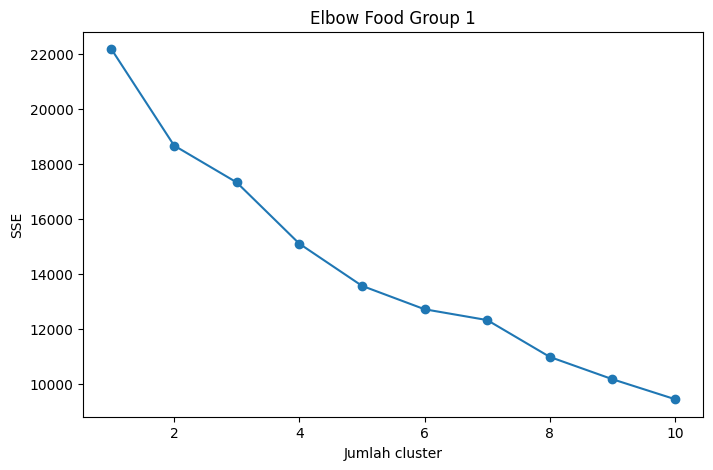

In [164]:
# Elbow
sses = []

for food_scaled in foods_scaled:
  sse = []
  for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(food_scaled)
    sse.append(kmeans.inertia_)
    # print(sse)

  sses.append(sse)

# print(sses)

for i, sse in enumerate(sses) :
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, 11), sse, marker='o')
  plt.xlabel('Jumlah cluster')
  plt.ylabel('SSE')
  plt.title(f'Elbow Food Group {i+1}')
  plt.show()

In [165]:
from sklearn.metrics import silhouette_score

# Eksperimen dengan berbagai jumlah cluster
for k in range(2, 10):
  for i, food_scaled in enumerate(foods_scaled) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(food_scaled)
    silhouette_avg = silhouette_score(food_scaled, kmeans.labels_)
    print(f"For k={k}, the Silhouette Score is {silhouette_avg:.2f}")

For k=2, the Silhouette Score is 0.50
For k=3, the Silhouette Score is 0.34
For k=4, the Silhouette Score is 0.22
For k=5, the Silhouette Score is 0.25
For k=6, the Silhouette Score is 0.25
For k=7, the Silhouette Score is 0.25
For k=8, the Silhouette Score is 0.26
For k=9, the Silhouette Score is 0.25


In [166]:
# 3 cluster : suggested, alternative, avoid
optimal_k = 3

for i, food_scaled in enumerate(foods_scaled) :
  kmeans = KMeans(n_clusters=optimal_k, random_state=42)
  clusters = kmeans.fit_predict(food_scaled)
  foods_df[i]['Cluster'] = clusters

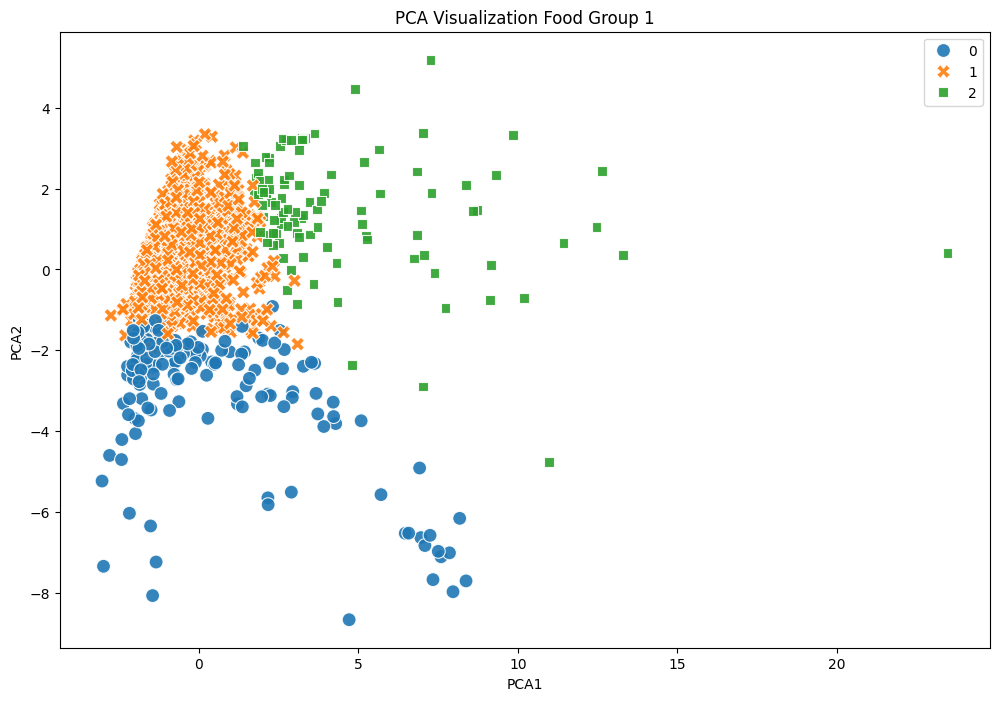

In [167]:
for i, food_df in enumerate(foods_df) :
  plt.figure(figsize=(12, 8))
  sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=food_df, palette='tab10', alpha=0.9, s=100, style='Cluster')

  plt.title(f'PCA Visualization Food Group {i+1}')
  plt.legend(loc='best')
  plt.show()

   Caloric Value  Carbohydrates    Sugars   Protein  Dietary Fiber  \
0       0.022258       0.386812  0.027170  0.154249       0.998828   
1      -0.225448      -0.149940 -0.068295 -0.238217      -0.207428   
2       1.967549       0.703619  0.562816  1.866398       0.219324   

   Saturated Fats  Monounsaturated Fats  Polyunsaturated Fats  Vitamin D  \
0       -0.316883             -0.353051             -0.260708  -0.201531   
1       -0.154868             -0.169502             -0.169191   0.057217   
2        1.891752              2.080631              1.927700  -0.180816   

   Magnesium  Potassium  Nutrition_Density  Protein_Ratio  Carbohydrate_Ratio  \
0   0.828761   1.149453           1.684269       0.371121            0.611838   
1  -0.235980  -0.278445          -0.262184      -0.110084            0.020286   
2   0.749652   0.605577          -0.408651       0.374904           -1.175248   

   Fat_Ratio  Nutrient_to_Calorie  Fiber_to_Sugar_Ratio  Saturated_Fat_Ratio  \
0  -0.679

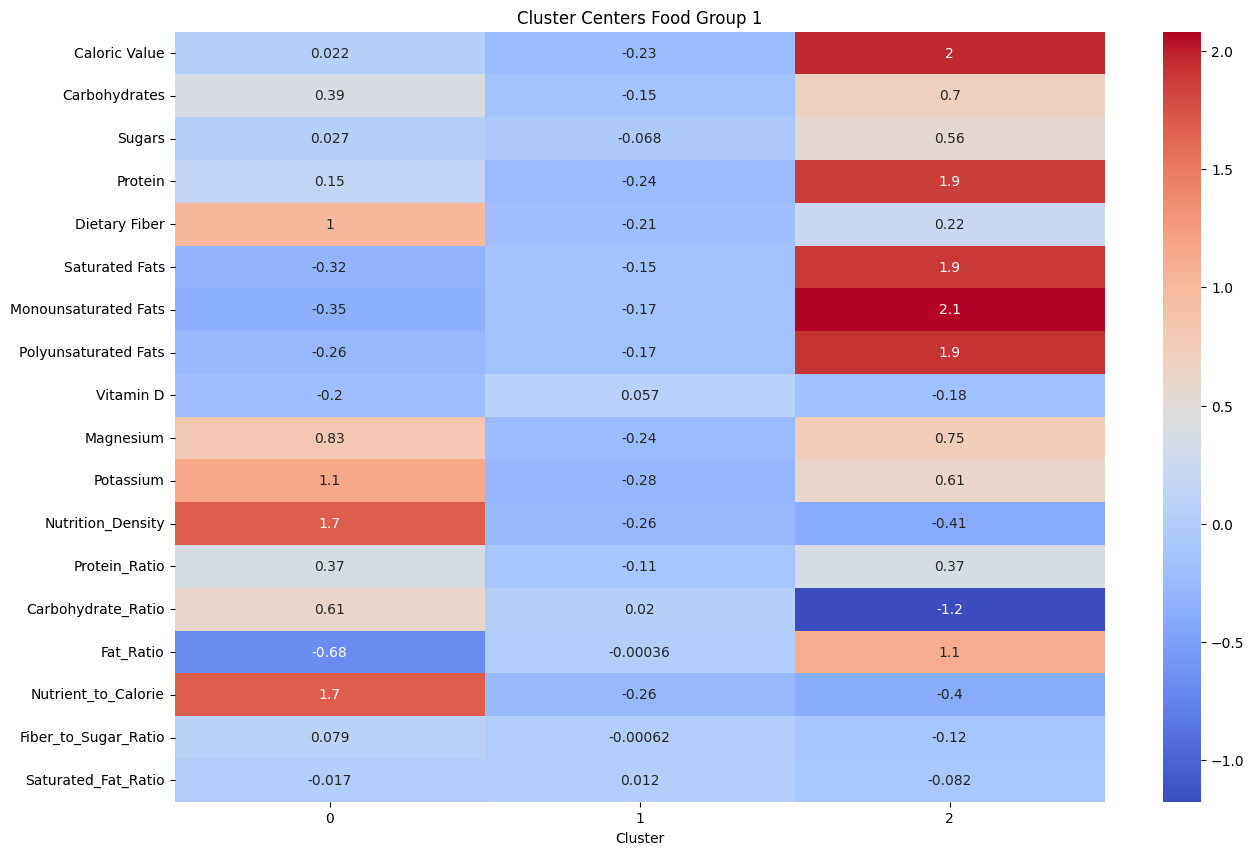

In [168]:
for i, food_scaled in enumerate(foods_scaled) :
  scaler = StandardScaler()
  scaler.fit(food_scaled)

  cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
  cluster_df = pd.DataFrame(cluster_centers, columns=food_indices)
  cluster_df['Cluster'] = range(optimal_k)

  print(cluster_df)

  fig, ax = plt.subplots(figsize=(15, 10))
  sns.heatmap(cluster_df.set_index('Cluster').T, annot=True, cmap='coolwarm', ax=ax)
  plt.title(f'Cluster Centers Food Group {i+1}')
  plt.show()

Pembagian kluster menjadi 3 kategori (rekomendasi, aman, dan jangan dimakan oleh penderita diabetes) bisa dilakukan dengan analisis lebih dalam terhadap hasil clustering. Berikut adalah langkah-langkah untuk interpretasi dan analisis:

**1. Interpretasi Heatmap**

Dari heatmap di atas:
- **Cluster 0**: Nilai tinggi pada "Dietary Fiber", "Magnesium", dan "Potassium", serta rendah pada "Saturated Fats" dan "Sugars". Ini cocok untuk makanan sehat dengan kandungan serat tinggi.
- **Cluster 1**: Nilai rendah hampir di semua fitur kecuali sedikit kenaikan di "Vitamin D". Bisa jadi kategori makanan kurang bernutrisi atau makanan ringan.
- **Cluster 2**: Nilai sangat tinggi pada "Sugars", "Saturated Fats", dan lemak lainnya. Ini menunjukkan makanan tinggi kalori dan gula, tidak cocok untuk penderita diabetes.

**2. Kategorisasi Kluster**
- **Cluster 0 (Rekomendasi)**: Makanan ini memiliki kandungan serat tinggi, rendah gula, dan rendah lemak jenuh. Cocok untuk semua, termasuk penderita diabetes.
- **Cluster 1 (Aman dimakan oleh penderita diabetes)**: Makanan dengan nilai nutrisi sedang atau netral, tanpa kandungan gula atau lemak tinggi. Aman untuk penderita diabetes, tetapi bukan makanan dengan nutrisi istimewa.
- **Cluster 2 (Jangan dimakan oleh penderita diabetes)**: Makanan dengan kadar gula tinggi, lemak jenuh tinggi, dan rendah serat. Tidak cocok untuk penderita diabetes karena meningkatkan kadar gula darah.

In [154]:
for clust in range(0, optimal_k) :
  print(f"List of cluster {clust}")
  for i, food_df in enumerate(foods_df) :
    print(f"\nFood Group {i+1}")
    print(food_df[food_df['Cluster'] == clust]['food'].head(10))
    print("\n\n")

List of cluster 0

Food Group 1
41             apple butter
42                fruit jam
51              apricot jam
65                corn rice
69        burrito with beef
79         chicken egg roll
80       vegetable egg roll
89          egg dinner roll
104    arroz con abichuelas
113             ladyfingers
Name: food, dtype: object



List of cluster 1

Food Group 1
203                       beef stock
224                      tomato soup
788                       wheat bran
930          pokeberry shoots cooked
1017            coriander leaves raw
1020                   parsley dried
1055                   parsley fresh
1074             garden cress cooked
1076            dandelion greens raw
1449    profeel proteiinirahka valio
Name: food, dtype: object



List of cluster 2

Food Group 1
0                        cream cheese
1                   neufchatel cheese
2    requeijao cremoso light catupiry
3                      ricotta cheese
4                cream cheese low fat
5     

### Save The Clustered Data

In [38]:
# making clusters data
clusters_df = []
for i in range(0, optimal_k) :
  if len(clusters_df) == i :
    clusters_df.append([])

  clusters_df[i] = foods_df[0][foods_df[0]["Cluster"] == i]

for i in range(0, optimal_k) :
  for j in range(1, len(foods_df)) :
    clusters_df[i] = pd.concat([clusters_df[i], foods_df[j][foods_df[j]["Cluster"] == i]])


In [39]:
# print the data
for i in range(0, len(clusters_df)) :
  print(f"Cluster {i+1} length: {len(clusters_df[i])}")

Cluster 1 length: 174
Cluster 2 length: 951
Cluster 3 length: 107


In [40]:
# clean some features
for i in range(0, len(clusters_df)) :
  clusters_df[i].drop(columns=['Cluster', 'PCA1', 'PCA2', 'Total_Nutrition', 'Nutrition_Density',
    'Protein_Ratio', 'Carbohydrate_Ratio', 'Fat_Ratio',
    'Nutrient_to_Calorie', 'Fiber_to_Sugar_Ratio', 'Saturated_Fat_Ratio', 'Micronutrient_Sum'], inplace=True)


C:\Users\fixri\AppData\Local\Temp\ipykernel_12640\2160502740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df[i].drop(columns=['Cluster', 'PCA1', 'PCA2', 'Total_Nutrition', 'Nutrition_Density',
C:\Users\fixri\AppData\Local\Temp\ipykernel_12640\2160502740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters_df[i].drop(columns=['Cluster', 'PCA1', 'PCA2', 'Total_Nutrition', 'Nutrition_Density',
C:\Users\fixri\AppData\Local\Temp\ipykernel_12640\2160502740.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

In [41]:
# Directory for saving cluster data
cluster_dir = "clustered_food"
os.makedirs(cluster_dir, exist_ok=True)

# Ensure unique "train" folder names
num_train = 0
while os.path.exists(f"{cluster_dir}/train{num_train}"):
  num_train += 1
train_folder = f"{cluster_dir}/train{num_train}"
os.makedirs(train_folder)

# Save each cluster's data to CSV files
for i, cluster_df in enumerate(clusters_df):
  cluster_file = f"{train_folder}/cluster_{i}.csv"
  cluster_df.to_csv(cluster_file, index=False)

print(f"Cluster data saved in '{cluster_dir}'")
print(f"Unique train folder created: '{train_folder}'")

Cluster data saved in 'clustered_food'
Unique train folder created: 'clustered_food/train1'


In [28]:
# Optional
raw_dir_base = f"{cluster_dir}/raw"

# Ensure unique "raw" folder names
num_raw = 0
while os.path.exists(f"{raw_dir_base}{num_raw}"):
    num_raw += 1
raw_dir = f"{raw_dir_base}{num_raw}"
os.makedirs(raw_dir, exist_ok=True)

# Save each food group's data to CSV files
for i, food_df in enumerate(foods_df):
    food_file = f"{raw_dir}/food_group_{i+1}.csv"
    food_df.to_csv(food_file, index=False)

print(f"Food group data saved in '{raw_dir}'")

Food group data saved in 'clustered_food/raw1'


In [ ]:
# Optional
!zip -r clustered_food.zip clustered_food

## Finalization

### Extract Tags of Food Cluster

In [2]:
directory = 'clustered_food/train1'

# List to hold the dataframes
dataframes = []

# Iterate over all the files in the directory
for filename in os.listdir(directory):
    if filename.startswith("cluster") and filename.endswith(".csv"):
        file_path = os.path.join(directory, filename)
        # Read the CSV file and append to the list
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all dataframes in the list
combined_df = pd.concat(dataframes, ignore_index=True)

In [ ]:
# get all food name
combined_food = " ".join([i for i in combined_df.food.to_list()])

In [ ]:
# split all word in food name
food_tags = [i for i in combined_food.split(" ") if i != "with" or i != "in" or i != "on" or i != "side" or i != "eyed" or i != "dish"]

# change the data to set, to prevent duplicate word
food_tags = set(food_tags)

In [ ]:
food_tags

In [ ]:
len(food_tags)

In [ ]:
class SetEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

data_tags = json.dumps(food_tags, cls=SetEncoder)
print(data_tags)

In [ ]:
with open('food_tags.json', 'w') as f:
    json.dump(data_tags, f)

### Get Top 250

In [ ]:
vector_tags = CountVectorizer(max_features=250)

vector_tags.fit_transform(combined_df.food)

top_250_tags = vector_tags.get_feature_names_out()

top_250_tags

array(['almonds', 'american', 'apple', 'apricot', 'arroz', 'asparagus',
       'bacon', 'bagel', 'baked', 'banana', 'bar', 'barbecue', 'barley',
       'bean', 'beans', 'beef', 'biscuit', 'black', 'blue', 'bologna',
       'bran', 'bread', 'broccoli', 'broth', 'brown', 'burger', 'burrito',
       'butter', 'cabbage', 'caesar', 'cake', 'canned', 'caramel',
       'carrots', 'cashew', 'celery', 'cereal', 'cheese', 'cheeseburger',
       'cherries', 'chicken', 'chili', 'chinese', 'chips', 'chocolate',
       'cinnamon', 'coated', 'coca', 'coconut', 'cola', 'coleslaw', 'con',
       'cooked', 'cookies', 'corn', 'cornmeal', 'cottage', 'cowpeas',
       'cracker', 'crackers', 'cranberry', 'cream', 'crispy', 'crookneck',
       'crust', 'cucumber', 'dinner', 'donut', 'double', 'dressing',
       'dried', 'dry', 'egg', 'english', 'fat', 'figs', 'fish', 'flakes',
       'flour', 'free', 'french', 'fried', 'fries', 'frosting', 'frozen',
       'fruit', 'fudge', 'garlic', 'germ', 'goat', 'graham'

In [4]:
with open('top_250_tags.json', 'w') as f:
    json.dump(list(top_250_tags), f)